<a href="https://colab.research.google.com/github/souchem23/data-science-coursework/blob/main/Unit2/SoumikC_Unit2Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preparation

Hello! Welcome to my project!

At a high level, I created a prediction model for determining the probability for a network attack to be of a certain payload size or not. This project is extremely useful as it can create a model to forecast the behavior of certain cyber attacks, which can be used to create more effective counter-measures.

Here are some buzz words to get you started: Cybersecurity! Network attacks! DDOS and Intrusion attacks!

Note: For this writeup, "cyber attacks" and "network attacks" are used interchangeably.

Heads up! A more detailed form of each section is present near the end of the writeup.



Start by importing packages: preliz, numpy, arviz, pymc, pandas.

---



In [7]:
# Installing packages
!pip install preliz
import preliz as pz

import numpy as np
import pymc as pm
import arviz as az
import pandas as pd

## Introduction (Context)

### Motivation

*   DDOS attacks and other cyber security attacks have grown in prevalence in our modern society.
*   Contributed to the loss of infrastructure, medical records, and government documents.

###Relevance

* According to [a10networks.com](https://www.a10networks.com/blog/5-most-famous-ddos-attacks/://), in November 2021, there was a large DDOS attack against Azure, a Windows cloud computing service.
* 3.45 Terabytes were sent per second (large packet size) and 340 million packets sent per second.

###How is it Measurable?
* Attackers make specific choices about the behavior of their network attack.
* One of these features is the amount of data sent by packet across the network.
* Dire need to detect the probability of certain features occuring more frequently
* I want to analyze the likelihood of an attacker using above average packet sizes for volumetric attacks.
* Confident that most DDOS and Intrusion attacks will have packet sizes with greater than 500 Megabytes because more data increases network downtime.

## Prior (Network Attack Payloads)

Below are the assumptions made for this model based on statistical data and general knowledge about the topic.

1.   Intrusion attacks and DDOS attacks will grow in severity and occurence. This assumption is based on the "[Cisco Annual Internet Report](https://www.cisco.com/c/en/us/solutions/collateral/executive-perspectives/annual-internet-report/white-paper-c11-741490.html)", which displays an increasing trend in cyber attacks from 2018 (7.9 million) to 2023 (15.4 million).
2.   Based on my prior knowledge, I am assuming that a majority of these cyber attacks will be based on TCP. Most network attacks are based on TCP. This ensured data transmission and thus requires more data (informing my confident prior). This is also justified by [Cloudfare](https://blog.cloudflare.com/ddos-threat-report-for-2024-q2/#:~:text=Network%2Dlayer%20DDoS%20attack%20vectors&text=SYN%20floods%20came%20in%20second,all%20network%2Dlayer%20DDoS%20attacks.://): 38% of network layer DDOS attacks are based on the TCP protocol.
3. The attacker has the freedom to chose either a large or small payload size for the network attacks. Thus, we can assume that each attack is indpendent and there is a likely chance of each situation occuring.
4. According to [Cloudfare](https://blog.cloudflare.com/ddos-attacks-have-evolved-and-so-should-your-ddos-protection/), in 2020, 60% of volumetric attacks were under 500 Mb. However, due to the recent statistics that portray an increasing number of network attacks, I assume that around 70% of the volumetric attacks will have packet sizes over 500 Mb.

For this project, we care about the payload size and the attack itself. I am fairly confident in my predictions, especially since Cloudfare has shown upwards trends; I believe that a beta value of 30 and an alpha value of 70 will accurately reflect my confidence, especially with my thousands of data points.

<Axes: >

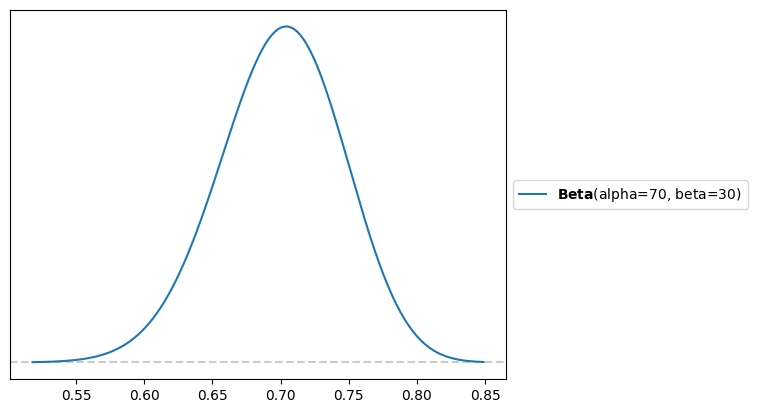

In [4]:
# Beta distribution for the prior
pz.Beta(alpha=70,beta=30).plot_pdf()

In [6]:
network_prior = pz.Beta(alpha=70,beta=30)

# Calculating mode of prior
network_prior_mode = (network_prior.alpha - 1)/(network_prior.alpha + network_prior.beta - 2)

# Mean, median, and mode of prior to see different interpretations of my prior
network_prior.mean(), network_prior.median(), network_prior_mode

(0.7, 0.7013380272307655, 0.7040816326530612)

## Likelihood (Network Attacks Dataset Interpretation)

We have a distribution for our prior knowledge. It is important to keep in mind that this data does not include the actual observations from thousands of network data attacks. In order to make more accurate predictions, we will have to take into account observations from real world data. Our real world data and observations will inform our likelihood.

* Our dataset is going to be coming from "Cyber Security Attacks" by Uma Venugopal on Kaggle.
* This data has certain characteristics which will not be useful for our analysis.
*Our data for this project will only involve the network attack size.

In the subsequent code block, the dataset will be processed to become a form that is useful for us. We will only filter if the AttackType is an Intrusion or DDOS (volumetric attack) and analyze the PacketLength for these entries.

In [56]:
# read in the network dataset
url_network = 'https://raw.githubusercontent.com/souchem23/data-science-coursework/main/cybersecurity_attacks.csv'
#feed that string into the pandas read csv function
network = pd.read_csv(url_network)

In [57]:
# Query only for Intrustion and DDOS attacks
network = network.query('AttackType == "Intrusion" or AttackType == "DDOS"')

In [58]:
network

,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,PacketLength,Packet Type,Traffic Type,Payload Data,...,Action Taken,Severity Level,User Information,Device Information,Network Segment,Geo-location Data,Proxy Information,Firewall Logs,IDS/IPS Alerts,Log Source
1,10/5/2023 8:40,175.213.52.16,71.52.107.88,45548,26000,TCP,1500,Control,DNS,Similique perferendis iure aspernatur minima n...,...,Blocked,Medium,Mohanlal Chakraborty,Mozilla/5.0 (X11; Linux i686) AppleWebKit/532....,Segment A,"Katihar, Tamil Nadu",197.151.152.237,Log Data,NaN,Firewall
2,8/31/2020 21:19,21.219.2.221,93.47.147.100,1176,46740,ICMP,1500,Control,HTTP,Vitae ipsa doloribus omnis quas dolores. Asper...,...,Logged,High,Gokul Badami,Mozilla/5.0 (compatible; MSIE 5.0; Windows CE;...,Segment B,"Thanjavur, Andhra Pradesh",181.255.225.81,NaN,NaN,Server
3,7/21/2022 3:34,211.180.180.240,214.137.121.86,21812,41700,UDP,1500,Control,DNS,Odit quae aspernatur fugit alias a sunt. Velit...,...,Logged,Medium,Nitara Sahota,Opera/8.42.(X11; Linux x86_64; pa-IN) Presto/2...,Segment B,"Bathinda, Manipur",33.122.176.12,NaN,Alert Data,Server
4,6/21/2022 2:57,20.222.1.137,71.237.182.185,29140,22576,TCP,1500,Data,DNS,Nesciunt magnam voluptates quae. Impedit elige...,...,Logged,Low,Aarna Krishnamurthy,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_3...,Segment C,"Mumbai, Goa",NaN,NaN,NaN,Server
14,1/29/2022 19:21,117.125.149.125,219.227.119.127,20423,14549,UDP,1500,Control,HTTP,Veniam quibusdam dolor iste ducimus quidem ea ...,...,Blocked,Medium,Kiaan Thaman,Opera/9.31.(Windows NT 6.0; oc-FR) Presto/2.9....,Segment C,"Jalna, West Bengal",NaN,NaN,Alert Data,Firewall
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39974,1/24/2021 19:58,14.20.11.46,4.159.20.215,64984,19416,TCP,64,Control,FTP,Est aliquam adipisci. Sequi laborum beatae rer...,...,Ignored,Medium,Aarav Deshpande,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/534.0...,Segment C,"Aizawl, Karnataka",23.239.156.83,Log Data,NaN,Server
39979,8/13/2022 3:01,3.77.168.85,39.84.59.206,44369,36496,UDP,64,Data,FTP,Fugiat magni ut tempore a. Mollitia adipisci d...,...,Ignored,Low,Kaira Jhaveri,Mozilla/5.0 (Windows; U; Windows NT 6.0) Apple...,Segment C,"Berhampore, Karnataka",120.236.18.22,Log Data,NaN,Firewall
39984,4/7/2022 3:41,67.149.133.123,73.128.201.233,3435,50888,UDP,64,Data,DNS,Maxime illo maxime eaque necessitatibus quos r...,...,Logged,High,Dhanuk Magar,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_3)...,Segment A,"Bareilly, Uttarakhand",NaN,Log Data,NaN,Server
39985,1/14/2022 18:33,153.41.124.179,65.176.68.136,14476,49301,UDP,64,Data,DNS,Velit eaque tenetur possimus quos adipisci qui...,...,Blocked,High,Nirvi Khosla,Mozilla/5.0 (compatible; MSIE 8.0; Windows 98;...,Segment B,"Erode, Madhya Pradesh",NaN,NaN,Alert Data,Firewall


In [59]:
# Find number of packets greater/less than 500 Megabytes
network[['PacketLength']]
greaterThan500 = network.query('PacketLength > 500').shape[0]
lessThan500 = network.query('PacketLength < 500').shape[0]

In [60]:
# Number of attacks with packets greater than 500 Megabytes
greaterThan500

9177

In [61]:
# Number of attacks with packets less than 500 Megabytes
lessThan500

4082

In [62]:
totalLength = greaterThan500+lessThan500
totalLength

13259

We can now create a likelihood distribution. We know that the total number of data entries is 13259 from the previous code segment. Thus, we can create a distribution in order to represent our likelihood based on our observations and evidence from real life.

<Axes: >

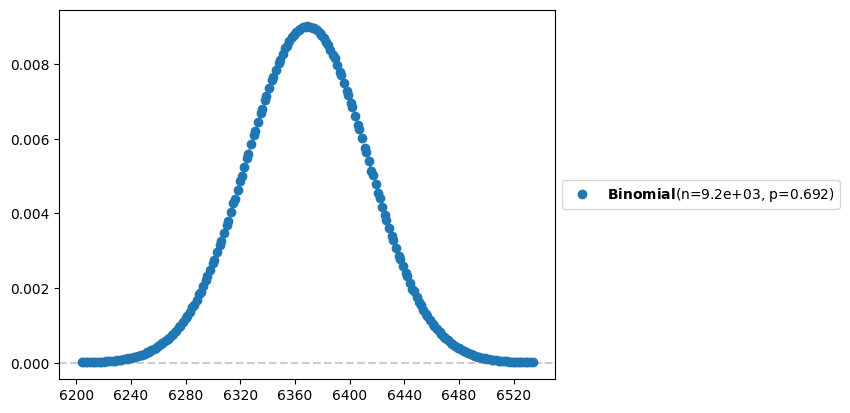

In [63]:
# Likelihood distribution
pz.Binomial(n = 9202, p = 9177/13259).plot_pdf()

## Posterior (Making Predictions)

In our prior, I denoted that I was approximately 70% confident that network attack throughput would be above 500 Mbps. This prior was based on my thoughts on the state of cybersecurity in our modern society. However, I want to incorporate more real world data in order to strengthen my prediction. The cybersecurity dataset from Kaggle includes data form a variety of attacks. For this project, I chose to include the data entries that inlude either "Intrusion" or "DDOS", as these are the attacks that incorporate very large or small amounts of packet sizes. In total, there were 13,259 data entries that were a part of the likelihood. Of these data entries, 9177 attacks had packet sizes greater than 500 megabytes while 4082 attacks have packet sizes that are lower than 500 megabytes.

The subsequent section will show my posterior using th PYMC library to visualize my distribution.


In [64]:
# 1 represents entries with packet sizes greater than 500 megabytes
greater500Network = np.repeat(1, 9177)

# 0 represents entries with packet sizes less than 500 megabytes

less500Network = np.repeat(0, 4082)

#combine the data entries into a single array
finalData = np.concatenate( [greater500Network,less500Network] )

with pm.Model() as wmby_FT_model:
  # prior
  θ = pm.Beta('θ' , alpha = 70. , beta = 30.)

  #likelihood
  y = pm.Bernoulli('y', p = θ, observed = finalData)

  #sample for posterior
  posterior_network = pm.sample(1000)


<Axes: title={'center': 'θ'}>

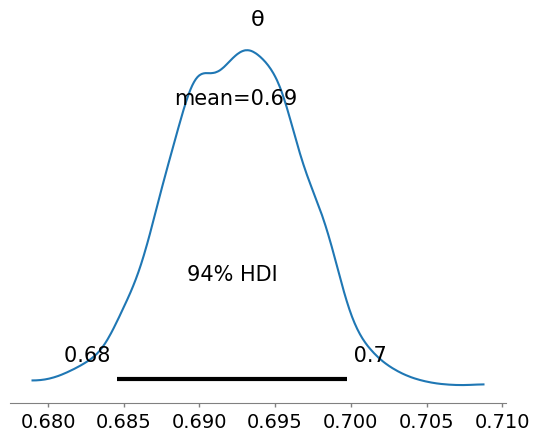

In [69]:
az.plot_posterior(posterior_network)

## PYMC Graph Analysis

### Conclusions
* The likelihood of a volumetric network attack of having greater than 500 Megabytes is around 69%.
* This result does not seem very surprising to me. In fact, it very closely aligns with my thoughts about behavior of network attacks.
* The mean of my prior is 70%, which is very close to the mean of the prediction which is 69%.
* The final posterior matches closely with my prior distribution that I chose. This emphasizes how my exepctations about a majority of network attacks using larger packet sizes matches the final posterior based on both observation and past generalizations.
* Although it is similar in nature, it raises some interesting questions about network attacks in general.
* Although my prior was accurate to the predictions for volumetric network attacks, differing patterns may be found for malware of ransomware attacks, which is worth investigating for more effective countermeasures.

### Insights
I feel that it is a good prediction, especially as it matches the growing trends of cyber attacks.In general, with much of our society becoming digital, network attacks have only been growing in prevalence. It has become much easier to share information online, motivating attackers to try and steal this information. Thus, the consideration of the changing times informs the strong prediction. However, it is limited in its scope since it considers these attacks on institutions, creating behaviors that may differ for attacks on different organizations or individuals.

## Want to know more? (Context and Assumptions)

### More Information on Context

DDOS attacks and various other cyber security attacks have grown in prominence in our modern society. With the digital revolution taking our society by storm, much of society has transformed into a digital world. We keep our personal data and secrets online, which motivates attackers to try and steal this sensitive data. This informs their decisions to create DDOS attacks and create havoc across numerous networks around the globe.

Specifically, these DDOS attacks have contributed to the loss of infrastructure, medical records, and classified government documents. This represents the extent to which DDOS attacks are being created and displays the dire need to develop better metrics of defense.

According to [a10networks.com](https://www.a10networks.com/blog/5-most-famous-ddos-attacks/://), in November 2021, Microsoft was able to successfully defend against an extremely large DDOS attack against Azure, one of their cloud computing services. This DDOS attack had a throughput of 3.45 Terabytes per second and had 340 million packets sent per second. This source classifies this cyber attack as one of the largest attacks ever recorded.

As a result, recognizing the size of certain cyber attacks can help in forecasting certain countermeasures. Since cyber attacks with larger payload sizes will have different signatures, recognizing these sizes can inform better prediction models.

Here is a bit more context behind the situation. Whenever an attacker decides to attack an institution, they have to make specific choices about the behavior of their network attack. For example, these attackers can choose to attack certain protocols, data sizes, and other features in order to create a unique attack. On the flip side, institutions and other organizations work to detect these network attacks by trying to detect these network attacks based on these behaviors. Specifically, intrusion detection systems are tools that can detect attacks and network anomolies from these behaviors. Thus, there is a dire need to detect the probability of certain features occuring in a network attack, so that these attacks can be detected in a more efficient manner.

For the purposes of this project, I will be looking at the amount of data that attackers use to send their attacks. I want to further understand the behavior of attackers by analyzing the likelihood of an attacker to use greater than the average packet sizes for volumetric attacks. I am confident that most DDOS and Intrusion attacks will have packet sizes with greater than 500 Megabytes because more data will allow attackers to cause more network downtime.

### More Information on Assumptions

The primary step in making our model for network attacks and their sizes is to consider our prior. Our prior is based on previous observations, options, or general knowledge about a certain topic. The prior is based off certain assumptions and context that is then used in conjunction with observable data to make a final prediction.

Below are the assumptions made for this model based on statistical data and general knowledge about the topic.


1.   Intrusion attacks and DDOS attacks will continue grow in severity and occurence, especially attacks that target larger companies and infrastructures that require a lot of data and time to infiltrate. This assumption is formed based on the "Cisco Annual Internet Report", which displays an increasing trend in cyber attacks from 2018 to 2023, rising from 7.9 to 15.4 million.
2.   Based on my prior knowledge of entwork attacks, I am assumng that a majority of these cyber attacks will be based on TCP. Most network attacks are based on TCP to ensure transmission of data. This often results in more data being sent over the network and informs my prior that a majority of these network attacks will be using TCP, which signifies the transmission of more data.
3. The assumption made in [2] is also justified by Cloudfare's dataset. Specifically, according to [Cloudfare](https://blog.cloudflare.com/ddos-threat-report-for-2024-q2/#:~:text=Network%2Dlayer%20DDoS%20attack%20vectors&text=SYN%20floods%20came%20in%20second,all%20network%2Dlayer%20DDoS%20attacks.://), 38% of network layer DDOS attacks are based on TCP which further supports my generalization made about the nature of the attack.
4. It is also important to consider the context behind the situation when making assumptions. Often, many people, including those that are unexperienced, are able to code simple cyber attacks due to custom libraries. They are able to exploit libraries and tools that would otherwise be used for good. Due to their inexperience, they are not aware of how to make network attacks efficient. This can often result in large network attacks or even incorrect ones that send too much data at once.
5. Another assumption is that the attacker has the freedom to chose either a large or small payload size for the network attacks. Thus, we can assume that each attack is indpendent and there is likely change of either situation occuring.
6. Another assumption that I am going to make is independence. I am assuming that any of the attacks, even if they occured subsequently, are not related to each other. Thus, I am claiming that each of the attacks were formed by individuals with differing thoughts and autonomy.
7. The final assumption will be based on the dataset about the average size of network attacks. According to [Cloudfare](https://blog.cloudflare.com/ddos-attacks-have-evolved-and-so-should-your-ddos-protection/), in 2020, 60% of volumetric attacks were under 500 Mb. However, due to the recent statistics that portray an increasing number of network attacks, I assume that around 70% of the volumetric attacks will have packet sizes over 500 Mb.

For this project, we care about the payload size and the attack itself. for this reason, we will use the alpha value of 70 and the beta value of 30. I am fairly confident in my predictions, especially since Cloudfare has seen upwards trends, I believe that the beta value will be 30 and the alpha value will be 70.